In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os
import matplotlib.pylab as pl

from art.attacks import FastGradientMethod
from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers.pytorch import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single =  DataLoader(test_dataset, batch_size=1)

In [3]:
epsilons = [0.001, .1, .2, .3, .4, .5, .6]
path = Path("C:/Users/Matach/OneDrive - Imperial College London/ICL/FYP/Experiments/saved_models/MNIST/FGSM/FGSM Adversarial/scenario_2")
file = "100%_2.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

## Model

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
    
    activations_fc2, activations_fc1 = [], []
    mask_fc2, mask_fc1 = torch.zeros(1, 200), torch.zeros(1, 512)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
    def forwardDetect(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        self.activations_fc1.append(x)
        x = F.relu(self.fc2(x))
        self.activations_fc2.append(x)
        x = self.fc3(x)
        return x
    
    def forwardMask(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))*self.mask_fc1
        x = F.relu(self.fc2(x))*self.mask_fc2
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 97.11 %


## MaskModel

In [6]:
class MaskModel(nn.Module):
    def __init__(self):
        super(MaskModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
    
    mask_fc2, mask_fc1 = torch.ones(1, 200), torch.ones(1, 512)
        
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))*self.mask_fc1.to(device)
        x = F.relu(self.fc2(x))*self.mask_fc2.to(device)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
mask_model = MaskModel().to(device)

# Load pre-trained model
mask_model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(mask_model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mask_model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
mask_classifier = PyTorchClassifier(
    model=mask_model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = mask_classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
MaskModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 97.11 %


## Pruning

In [7]:
model.eval() 
with torch.no_grad():
    for data, target in test_dataloader_single:
        output = model.forwardDetect(data.to(device))

activations_fc2 = model.activations_fc2
activations_fc1 = model.activations_fc1

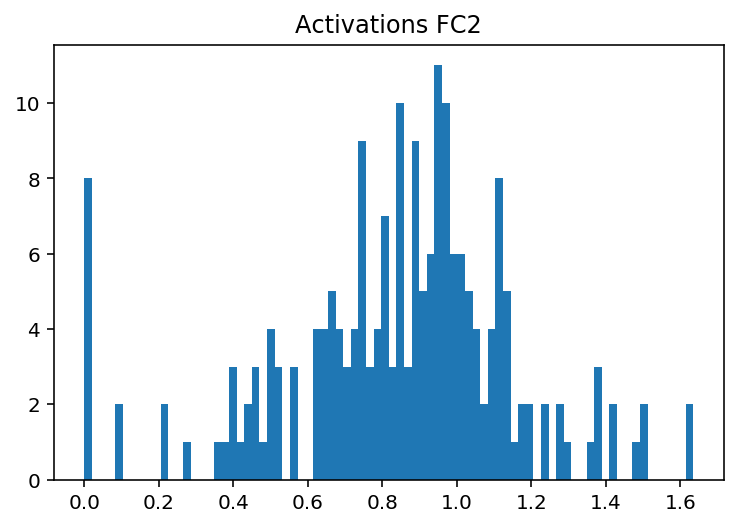

In [8]:
n = len(activations_fc2)
element0 = activations_fc2.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_fc2.pop()
    act[e+1,:,:] = elementX

mean_activations_fc2 = torch.mean(act,dim=[0,1])
ma = mean_activations_fc2.numpy()
plt.hist(ma,80)
plt.title('Activations FC2')
plt.show()

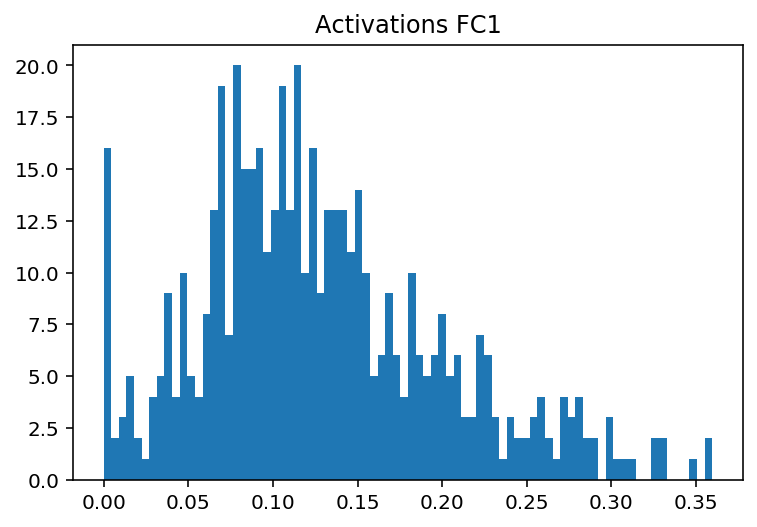

In [9]:
n = len(activations_fc1)
element0 = activations_fc1.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_fc1.pop()
    act[e+1,:,:] = elementX

mean_activations_fc1 = torch.mean(act,dim=[0,1])
ma = mean_activations_fc1.numpy()
plt.hist(ma,80)
plt.title('Activations FC1')
plt.show()

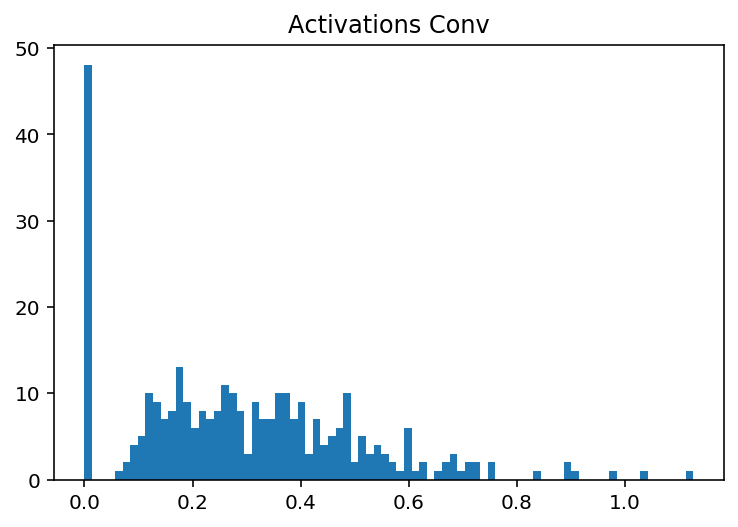

In [52]:
# n = len(activations_conv)
# element0 = activations_conv.pop()
# act = torch.zeros(n,element0.size(0),element0.size(1))
# act[0,:,:] = element0

# for e in range(n-1):
#     elementX = activations_conv.pop()
#     act[e+1,:,:] = elementX

# mean_activations_conv = torch.mean(act,dim=[0,1])
# ma = mean_activations_conv.numpy()
# plt.hist(ma,80)
# plt.title('Activations Conv')
# plt.show()

In [12]:
# save different masks for different percentages

masks_fc2 = dict()
masks_fc1 = dict()
# masks_conv = dict()

for percentage in range(9):
#     FC2
    s_ma_fc2, idx_ma_fc2 = torch.sort(mean_activations_fc2)
    m_fc2 = torch.ones(mean_activations_fc2.size()).to(device)
    nn_fc2 = mean_activations_fc2.size(0)
    ind_r_fc2 = round((percentage/10)*nn_fc2)
    m_fc2[idx_ma_fc2[:ind_r_fc2]] = 0.0
    n1_fc2 = m_fc2.sum()
    model.mask_fc2 = m_fc2
    masks_fc2[percentage/10] = model.mask_fc2
    
#     FC1
    s_ma_fc1, idx_ma_fc1 = torch.sort(mean_activations_fc1)
    m_fc1 = torch.ones(mean_activations_fc1.size()).to(device)
    nn_fc1 = mean_activations_fc1.size(0)
    ind_r_fc1 = round((percentage/10)*nn_fc1)
    m_fc1[idx_ma_fc1[:ind_r_fc1]] = 0.0
    n1_fc1 = m_fc1.sum()
    model.mask_fc1 = m_fc1
    masks_fc1[percentage/10] = model.mask_fc1


#     Conv
#     s_ma_conv, idx_ma_conv = torch.sort(mean_activations_conv)
#     m_conv = torch.ones(mean_activations_conv.size()).to(device)
#     nn_conv = mean_activations_conv.size(0)
#     ind_r_conv = round((percentage/10)*nn_conv)
#     m_conv[idx_ma_conv[:ind_r_conv]] = 0.0
#     n1_conv = m_conv.sum()
#     model.mask_conv = m_conv
#     masks_conv[percentage/10] = model.mask_conv

In [11]:
# evaluate with the new masks
acc = []
for (pg, mask_fc2), (pg, mask_fc1) in zip(masks_fc2.items(), masks_fc1.items()):
    model.mask_fc2 = mask_fc2
    model.mask_fc1 = mask_fc1
    
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader_single:
            output = model.forwardMask(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_dataloader_single.dataset))
        acc.append(acc_test)

    print("Pruned {}  Accuracy: {} %".format(pg, 100*acc_test))

Pruned 0.0  Accuracy: 97.11 %
Pruned 0.1  Accuracy: 97.09 %
Pruned 0.2  Accuracy: 97.08 %
Pruned 0.3  Accuracy: 96.89999999999999 %
Pruned 0.4  Accuracy: 96.61999999999999 %
Pruned 0.5  Accuracy: 96.19 %
Pruned 0.6  Accuracy: 95.84 %
Pruned 0.7  Accuracy: 94.81 %
Pruned 0.8  Accuracy: 83.83 %
Pruned 0.9  Accuracy: 10.100000000000001 %


## FGSM attack

In [19]:
fgsm_prune = dict()

# Run test for each epsilon and mask PG 
for (pg, mask_fc2), (pg, mask_fc1) in zip(masks_fc2.items(), masks_fc1.items()):
    print('\n Pruned {}'.format(pg))
    accuracies = []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    
    for e in epsilons:
        adv_crafter = FastGradientMethod(mask_classifier, eps=e)
        x_test_adv = adv_crafter.generate(x=x_test)
        predictions = mask_classifier.predict(x_test_adv)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        accuracies.append(accuracy)
        print("Epsilon: {}   Test Accuracy = {}".format(e, accuracy))

    results['accuracies'] = accuracies
    results['epsilons'] = epsilons
    fgsm_prune[pg] = results


 Pruned 0.0
Epsilon: 0.001   Test Accuracy = 0.9713
Epsilon: 0.1   Test Accuracy = 0.9546
Epsilon: 0.2   Test Accuracy = 0.9121
Epsilon: 0.3   Test Accuracy = 0.8564
Epsilon: 0.4   Test Accuracy = 0.7145
Epsilon: 0.5   Test Accuracy = 0.4071
Epsilon: 0.6   Test Accuracy = 0.1778

 Pruned 0.1
Epsilon: 0.001   Test Accuracy = 0.9713
Epsilon: 0.1   Test Accuracy = 0.9542
Epsilon: 0.2   Test Accuracy = 0.9097
Epsilon: 0.3   Test Accuracy = 0.8549
Epsilon: 0.4   Test Accuracy = 0.7164
Epsilon: 0.5   Test Accuracy = 0.4042
Epsilon: 0.6   Test Accuracy = 0.1767

 Pruned 0.2
Epsilon: 0.001   Test Accuracy = 0.9711
Epsilon: 0.1   Test Accuracy = 0.9535
Epsilon: 0.2   Test Accuracy = 0.9083
Epsilon: 0.3   Test Accuracy = 0.8507
Epsilon: 0.4   Test Accuracy = 0.7099
Epsilon: 0.5   Test Accuracy = 0.4014
Epsilon: 0.6   Test Accuracy = 0.1708

 Pruned 0.3
Epsilon: 0.001   Test Accuracy = 0.9686
Epsilon: 0.1   Test Accuracy = 0.9514
Epsilon: 0.2   Test Accuracy = 0.9044
Epsilon: 0.3   Test Accuracy

# Carlini attack

In [61]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

In [64]:
carlini_prune = dict()
constants = [0.1, 0.5, 1.0, 5, 10]
n = 1000

# Run test for each c and mask PG 
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    print('\n Pruned {}'.format(pg))
    accuracies, distances = [], []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    mask_model.mask_conv = mask_conv
    
    for init in constants:
        x_test_adv = CarliniL2(mask_classifier, x_test[:n], init_const=init)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        distances.append(L2distance(x_test[:n], x_test_adv))
        
        print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

    results['accuracies'] = accuracies
    results['distances'] = distances
    results['constants'] = constants
    carlini_prune[pg] = results


 Pruned 0.0
c: 0.1  Accuracy: 0.958  Distance: 0.171
c: 0.5  Accuracy: 0.935  Distance: 0.506
c: 1.0  Accuracy: 0.873  Distance: 1.145
c: 5  Accuracy: 0.454  Distance: 3.033
c: 10  Accuracy: 0.297  Distance: 3.624

 Pruned 0.1
c: 0.1  Accuracy: 0.96  Distance: 0.193
c: 0.5  Accuracy: 0.936  Distance: 0.49
c: 1.0  Accuracy: 0.884  Distance: 1.053
c: 5  Accuracy: 0.47  Distance: 2.968
c: 10  Accuracy: 0.306  Distance: 3.541

 Pruned 0.2
c: 0.1  Accuracy: 0.956  Distance: 0.12
c: 0.5  Accuracy: 0.931  Distance: 0.452
c: 1.0  Accuracy: 0.893  Distance: 0.885
c: 5  Accuracy: 0.519  Distance: 2.731
c: 10  Accuracy: 0.333  Distance: 3.409

 Pruned 0.3
c: 0.1  Accuracy: 0.95  Distance: 0.108
c: 0.5  Accuracy: 0.924  Distance: 0.429
c: 1.0  Accuracy: 0.89  Distance: 0.737
c: 5  Accuracy: 0.567  Distance: 2.356
c: 10  Accuracy: 0.377  Distance: 3.072

 Pruned 0.4
c: 0.1  Accuracy: 0.94  Distance: 0.093
c: 0.5  Accuracy: 0.918  Distance: 0.302
c: 1.0  Accuracy: 0.891  Distance: 0.561
c: 5  Accur

C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


c: 0.1  Accuracy: 0.107  Distance: nan
c: 0.5  Accuracy: 0.107  Distance: nan
c: 1.0  Accuracy: 0.107  Distance: nan
c: 5  Accuracy: 0.107  Distance: nan
c: 10  Accuracy: 0.107  Distance: nan


In [92]:
carlini_inf_prune = dict()
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
n = 1000
# Run test for each c and mask PG 
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    print('\n Pruned {}'.format(pg))
    accuracies = []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    mask_model.mask_conv = mask_conv
    
    for eps in epsilons:
        x_test_adv = CarliniLInf(mask_classifier, x_test[:n], epsilon=eps)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        
        print('eps:', eps, ' Accuracy:', acc)

    results['accuracies'] = accuracies
    results['epsilons'] = epsilons
    carlini_inf_prune[pg] = results


 Pruned 0.0
eps: 0.01  Accuracy: 0.96
eps: 0.1  Accuracy: 0.954
eps: 0.2  Accuracy: 0.902
eps: 0.3  Accuracy: 0.811
eps: 0.4  Accuracy: 0.671
eps: 0.5  Accuracy: 0.516
eps: 0.6  Accuracy: 0.382

 Pruned 0.1
eps: 0.01  Accuracy: 0.962
eps: 0.1  Accuracy: 0.954
eps: 0.2  Accuracy: 0.904
eps: 0.3  Accuracy: 0.812
eps: 0.4  Accuracy: 0.681
eps: 0.5  Accuracy: 0.52
eps: 0.6  Accuracy: 0.383

 Pruned 0.2
eps: 0.01  Accuracy: 0.959
eps: 0.1  Accuracy: 0.945
eps: 0.2  Accuracy: 0.899
eps: 0.3  Accuracy: 0.807
eps: 0.4  Accuracy: 0.674
eps: 0.5  Accuracy: 0.507
eps: 0.6  Accuracy: 0.384

 Pruned 0.3
eps: 0.01  Accuracy: 0.951
eps: 0.1  Accuracy: 0.933
eps: 0.2  Accuracy: 0.874
eps: 0.3  Accuracy: 0.774
eps: 0.4  Accuracy: 0.627
eps: 0.5  Accuracy: 0.474
eps: 0.6  Accuracy: 0.337

 Pruned 0.4
eps: 0.01  Accuracy: 0.943
eps: 0.1  Accuracy: 0.913
eps: 0.2  Accuracy: 0.838
eps: 0.3  Accuracy: 0.73
eps: 0.4  Accuracy: 0.573
eps: 0.5  Accuracy: 0.408
eps: 0.6  Accuracy: 0.304

 Pruned 0.5
eps: 0.01 

# Results
Refer to all_adversarial_exp.txt

### FGSM

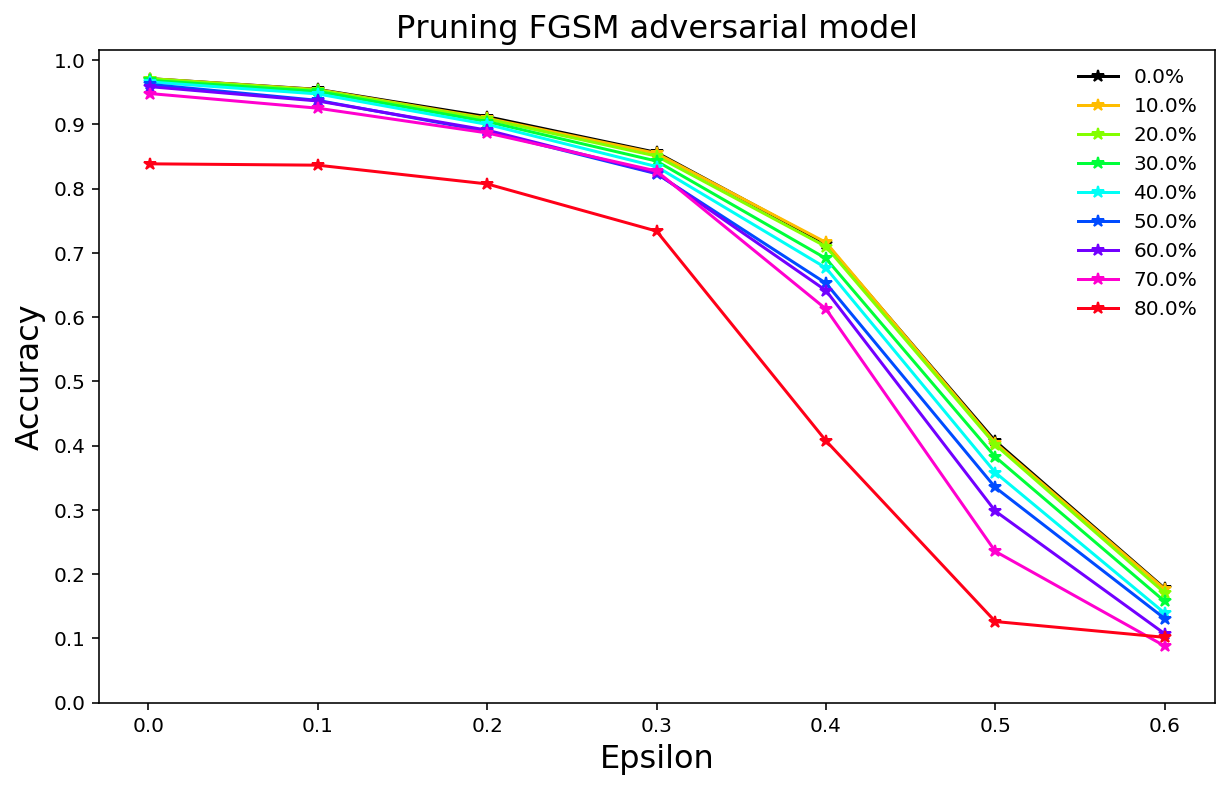

In [22]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))

# colors
n = len(fgsm_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] #half-black

for idx, (pg, results) in enumerate(fgsm_prune.items()):
    plt.plot(epsilons, results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .65, step=0.1))
plt.title("Pruning FGSM adversarial model", fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

### Carlini

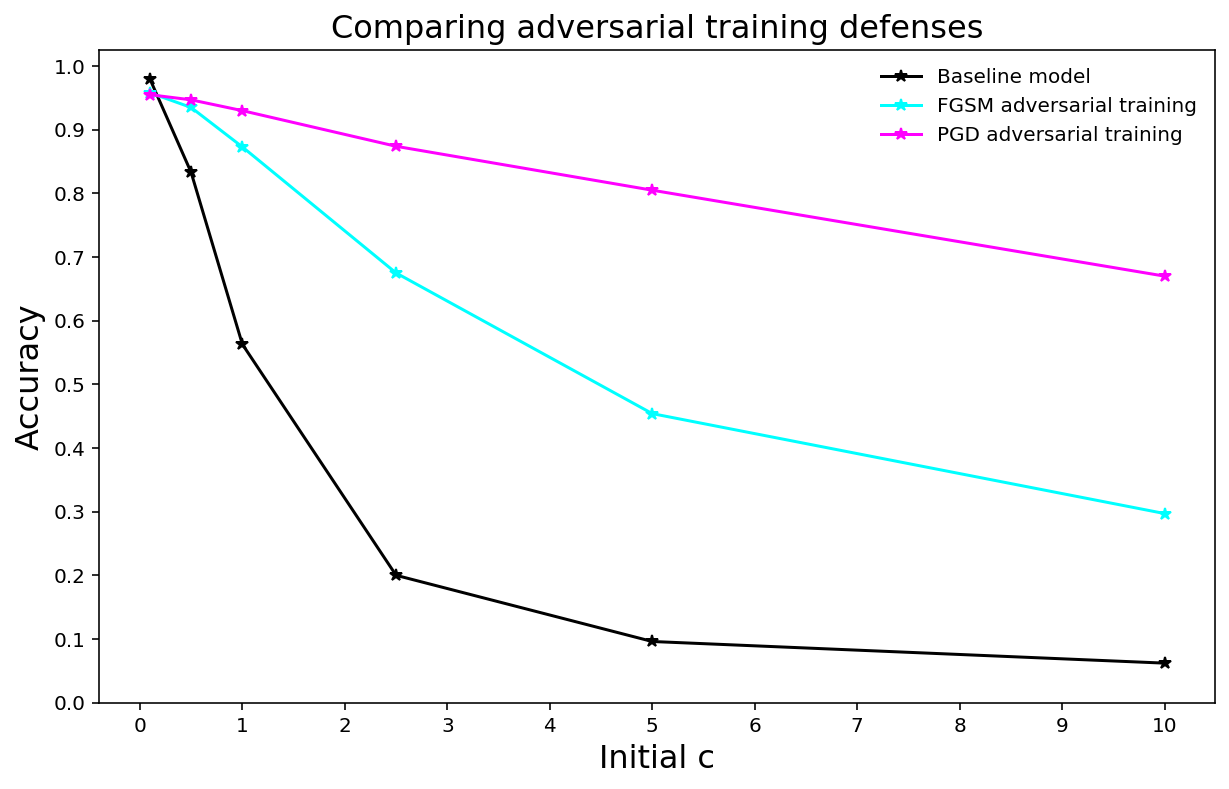

In [9]:
constants = [0.1, 0.5, 1.0, 2.5, 5, 10]

data = {
    'Baseline model': [0.979, 0.833, 0.563, 0.2, 0.096, 0.062],
    'FGSM adversarial training': [0.958, 0.935, 0.873, 0.675, 0.454, 0.297],
    'PGD adversarial training': [0.955, 0.947, 0.93, 0.874, 0.805, 0.67]
}

colors = ['black', 'cyan', 'fuchsia']

plt.figure(figsize=(10,6))


for idx, (pg, results) in enumerate(data.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 10.5, step=1))
plt.title("Comparing adversarial training defenses",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

In [ ]:


 Pruned 0.0
eps: 0.01  Accuracy: 0.956
eps: 0.1  Accuracy: 0.957
eps: 0.2  Accuracy: 0.913
eps: 0.3  Accuracy: 0.854
eps: 0.4  Accuracy: 0.752
eps: 0.5  Accuracy: 0.588
eps: 0.6  Accuracy: 0.412

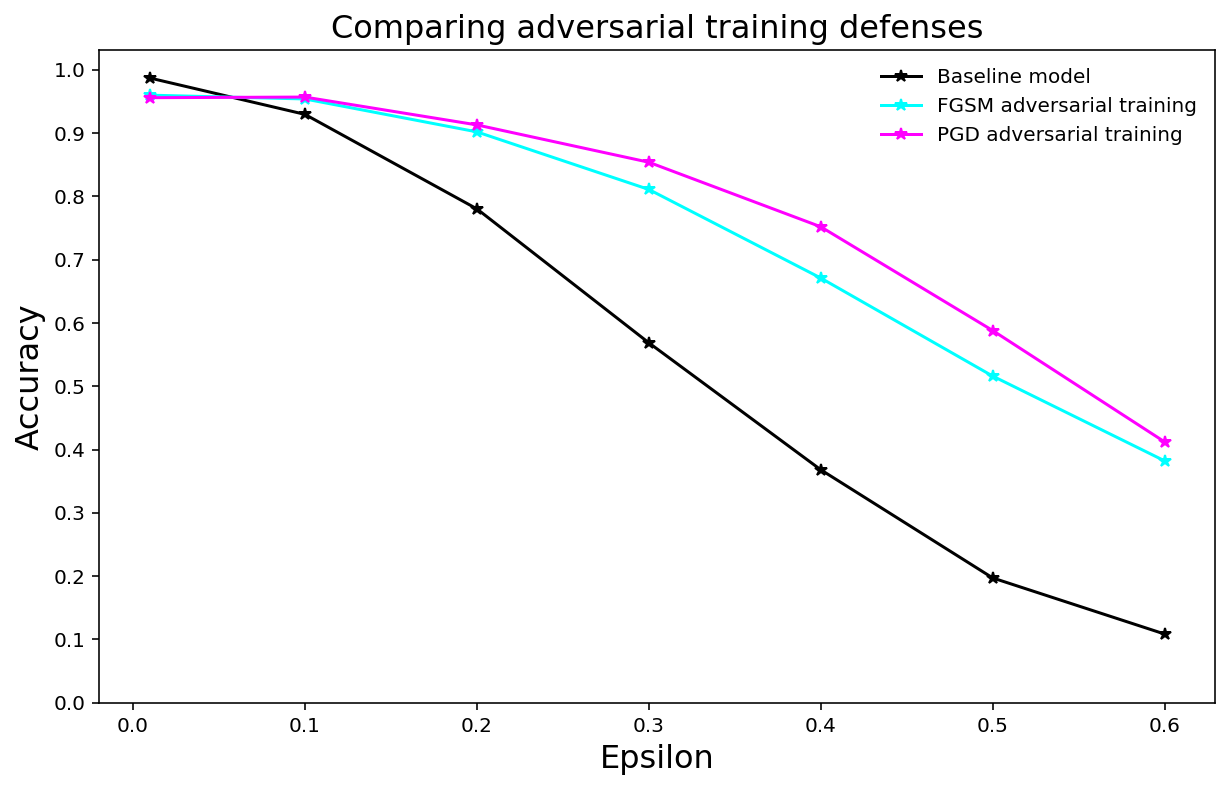

In [11]:
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

data_2 = {
    'Baseline model': [0.987, 0.92966667, 0.78033333, 0.56866667, 0.368, 0.197, 0.10833333],
    'FGSM adversarial training': [.96, .954, .902, .811, .671, .516, .382] ,
    'PGD adversarial training': [.956, .957, .913, .854, .752, .588, .412],
}
colors = ['black', 'cyan', 'fuchsia']


plt.figure(figsize=(10,6))


for idx, (pg, results) in enumerate(data_2.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.61, step=0.1))
plt.title("Comparing adversarial training defenses",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

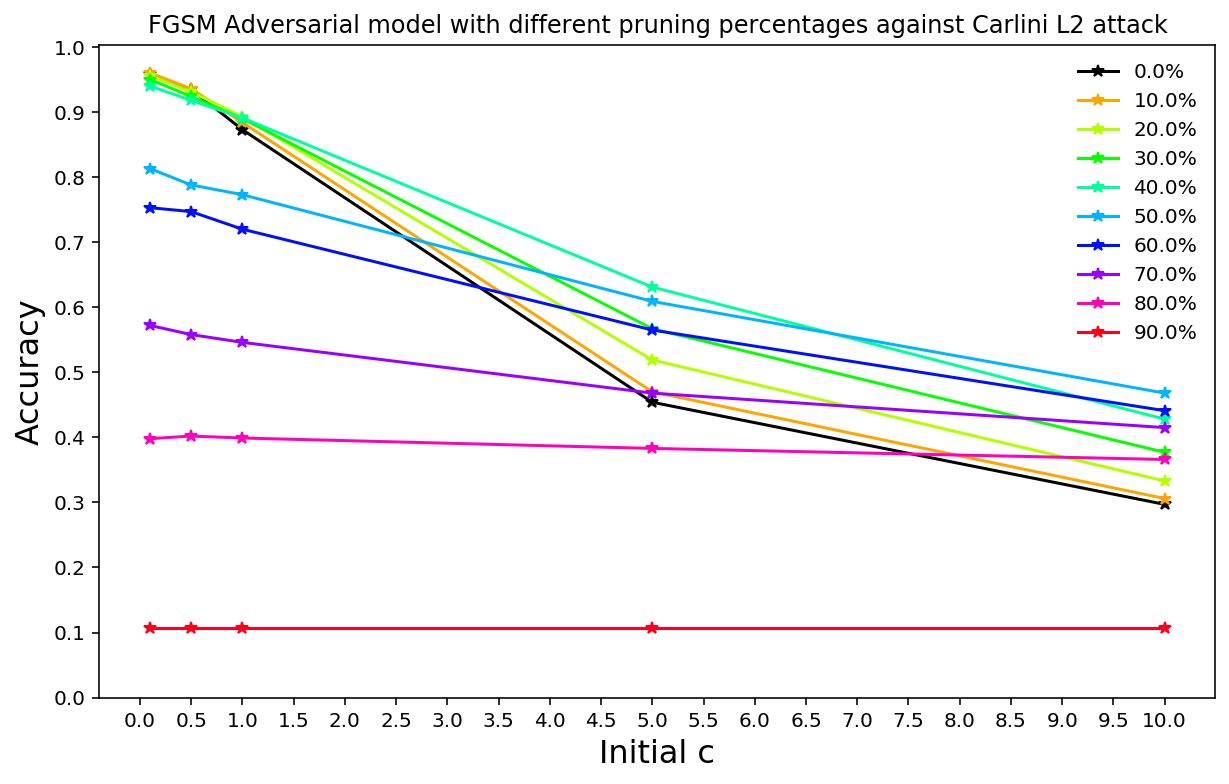

In [69]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))

# colors
n = len(carlini_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_prune.items()):
    plt.plot(results['constants'], results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 10.5, step=0.5))
plt.title("FGSM Adversarial model with different pruning percentages against Carlini L2 attack")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

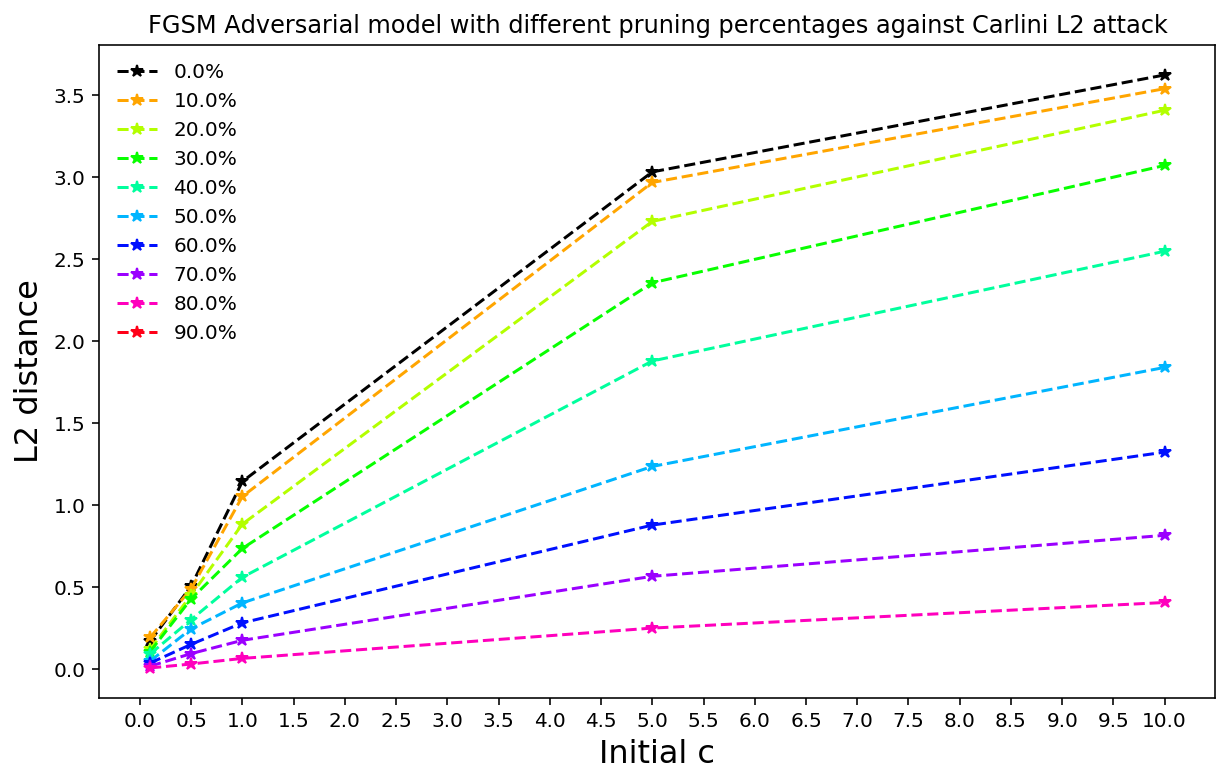

In [78]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))
# colors
n = len(carlini_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_prune.items()):
    plt.plot(results['constants'], results['distances'], "*--", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 10.5, step=0.5))
plt.title("FGSM Adversarial model with different pruning percentages against Carlini L2 attack")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

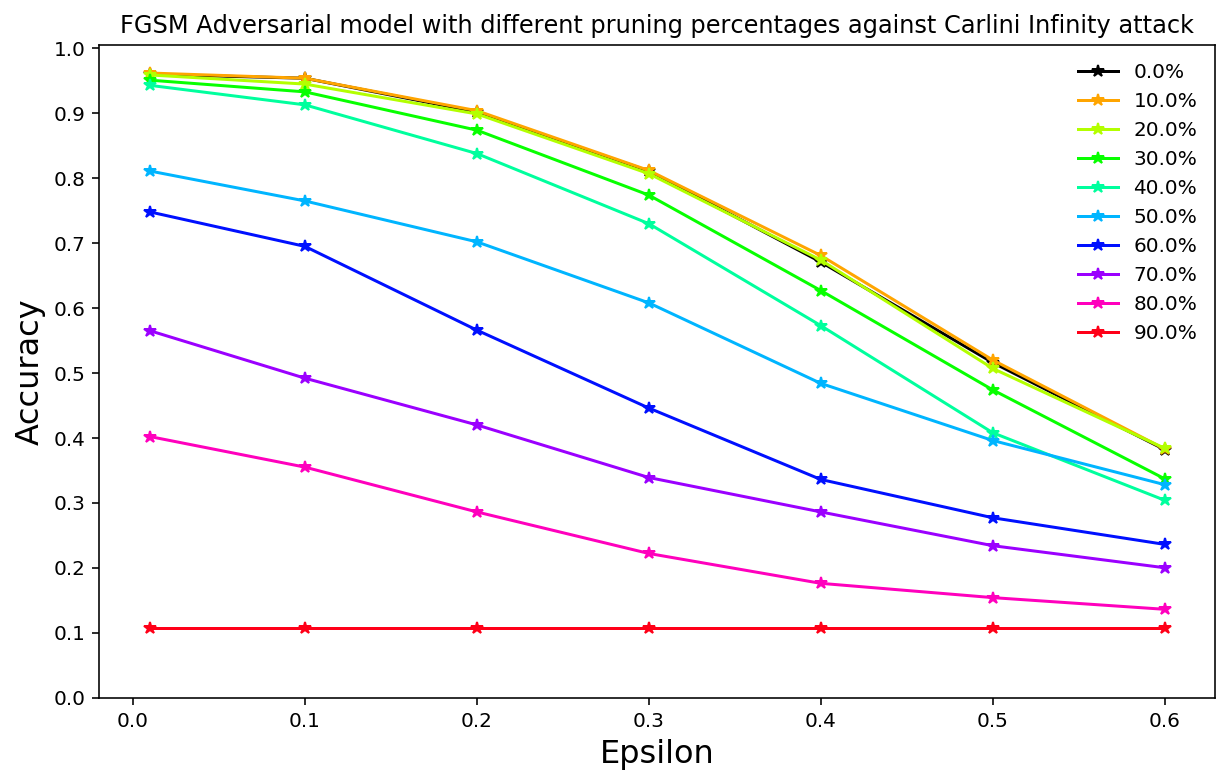

In [96]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))
# colors
n = len(carlini_inf_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_inf_prune.items()):
    plt.plot(results['epsilons'], results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.61, step=0.1))
plt.title("FGSM Adversarial model with different pruning percentages against Carlini Infinity attack")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

In [97]:
carlini_inf_prune

{0.0: {'accuracies': [0.96, 0.954, 0.902, 0.811, 0.671, 0.516, 0.382],
  'epsilons': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
 0.1: {'accuracies': [0.962, 0.954, 0.904, 0.812, 0.681, 0.52, 0.383],
  'epsilons': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
 0.2: {'accuracies': [0.959, 0.945, 0.899, 0.807, 0.674, 0.507, 0.384],
  'epsilons': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
 0.3: {'accuracies': [0.951, 0.933, 0.874, 0.774, 0.627, 0.474, 0.337],
  'epsilons': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
 0.4: {'accuracies': [0.943, 0.913, 0.838, 0.73, 0.573, 0.408, 0.304],
  'epsilons': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
 0.5: {'accuracies': [0.811, 0.765, 0.702, 0.608, 0.484, 0.396, 0.328],
  'epsilons': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
 0.6: {'accuracies': [0.748, 0.695, 0.566, 0.446, 0.336, 0.277, 0.236],
  'epsilons': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
 0.7: {'accuracies': [0.565, 0.492, 0.42, 0.339, 0.286, 0.234, 0.2],
  'epsilons': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
 0.8: 

In [98]:
carlini_prune

{0.0: {'accuracies': [0.958, 0.935, 0.873, 0.454, 0.297],
  'distances': [0.17080972432766273,
   0.5061249746759604,
   1.1447657721365492,
   3.032764331853359,
   3.6242118663426073],
  'constants': [0.1, 0.5, 1.0, 5, 10]},
 0.1: {'accuracies': [0.96, 0.936, 0.884, 0.47, 0.306],
  'distances': [0.19345924751833082,
   0.48979094694997816,
   1.0532032845244892,
   2.968296706577054,
   3.540517287708552],
  'constants': [0.1, 0.5, 1.0, 5, 10]},
 0.2: {'accuracies': [0.956, 0.931, 0.893, 0.519, 0.333],
  'distances': [0.12011608845718644,
   0.4517378395733734,
   0.8847670728282537,
   2.7308200447464994,
   3.408877699263394],
  'constants': [0.1, 0.5, 1.0, 5, 10]},
 0.3: {'accuracies': [0.95, 0.924, 0.89, 0.567, 0.377],
  'distances': [0.10760987078009004,
   0.4285203560306499,
   0.736547669662433,
   2.356378380057318,
   3.0722801309793604],
  'constants': [0.1, 0.5, 1.0, 5, 10]},
 0.4: {'accuracies': [0.94, 0.918, 0.891, 0.631, 0.428],
  'distances': [0.0926179526373744,
   0